In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import random

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

**System details**

In [3]:
import sys
import sklearn

print("Scikit-learn:", sklearn.__version__)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

Scikit-learn: 1.4.2
Pandas: 2.2.3
NumPy: 1.26.4


In [4]:
random.seed(2025) #For reproducibility
np.random.seed(2025)

In [5]:
df = pd.read_csv("Edge-IIoTset_clean.csv", low_memory=False)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945449 entries, 0 to 1945448
Data columns (total 46 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   arp.opcode                 float64
 1   arp.hw.size                float64
 2   icmp.checksum              float64
 3   icmp.seq_le                float64
 4   icmp.transmit_timestamp    float64
 5   http.content_length        float64
 6   http.response              float64
 7   tcp.ack                    float64
 8   tcp.ack_raw                float64
 9   tcp.checksum               float64
 10  tcp.connection.fin         float64
 11  tcp.connection.rst         float64
 12  tcp.connection.syn         float64
 13  tcp.connection.synack      float64
 14  tcp.dstport                float64
 15  tcp.flags                  float64
 16  tcp.flags.ack              float64
 17  tcp.len                    float64
 18  tcp.seq                    float64
 19  udp.port                   float64
 20  ud

In [7]:
print(df['Attack_type'].value_counts())

Attack_type
Normal                   1399624
DDoS_UDP                  121567
DDoS_ICMP                  67939
SQL_injection              50826
DDoS_TCP                   50062
Vulnerability_scanner      50026
Password                   49933
DDoS_HTTP                  48544
Uploading                  36957
Backdoor                   24026
Port_Scanning              19977
XSS                        15068
Ransomware                  9689
Fingerprinting               853
MITM                         358
Name: count, dtype: int64


In [8]:
# Creating a dictionary of Types
attacks = {'Normal': 0,'MITM': 1, 'Uploading': 2, 'Ransomware': 3, 'SQL_injection': 4,
       'DDoS_HTTP': 5, 'DDoS_TCP': 6, 'Password': 7, 'Port_Scanning': 8,
       'Vulnerability_scanner': 9, 'Backdoor': 10, 'XSS': 11, 'Fingerprinting': 12,
       'DDoS_UDP': 13, 'DDoS_ICMP': 14}
df['Attack_type'] = df['Attack_type'].map(attacks)

In [9]:
X = df.drop(columns=['Attack_label', 'Attack_type'])
y = df['Attack_type']

In [10]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Save test data for Raspberry Pi
np.save("RaspberryPi/X_test.npy", X_test.astype(np.float16))
np.save("RaspberryPi/y_test.npy", y_test.astype(np.float16))
np.save("RaspberryPi/feature_names_base.npy", X_test.columns.to_numpy())

**Random Forest base**

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train base Random Forest
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
start_train = time.time()
rf_model.fit(X_train, y_train)
train_time_base = time.time() - start_train

num_repetitions = 10    
inference_times = []
for _ in range(num_repetitions):
    start_pred = time.time()
    y_pred = rf_model.predict(X_test)
    inference_times.append(time.time() - start_pred)

# Compute median inference time
inference_time_base = np.median(inference_times)

# Compute test accuracy
test_accuracy_base = rf_model.score(X_test, y_test)

# Save model and check model size
model_filename = os.path.join("RaspberryPi", "base_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)
model_size_base = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB    

print(f" Modelo RF base")
print(f" Accuracy en test: {test_accuracy_base:.4f}\n")
print(f" Training time: {train_time_base:.4f}\n")
print(f" Inference time: {inference_time_base:.4f}\n")
print(f" Model Size: {model_size_base:.4f}\n")

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))


 Modelo RF base
 Accuracy en test: 0.9887

 Training time: 5.0219

 Inference time: 0.4515

 Model Size: 85.6072

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    279925
           1     1.0000    1.0000    1.0000        72
           2     0.9068    0.9061    0.9065      7391
           3     0.9591    0.9670    0.9630      1938
           4     0.8674    0.8968    0.8819     10165
           5     0.9549    0.9468    0.9508      9709
           6     1.0000    1.0000    1.0000     10012
           7     0.8844    0.8545    0.8692      9987
           8     0.9983    0.9997    0.9990      3995
           9     0.9802    0.9790    0.9796     10005
          10     0.9848    0.9844    0.9846      4805
          11     0.8656    0.8928    0.8790      3014
          12     0.9868    0.8772    0.9288       171
          13     1.0000    1.0000    1.0000     24313
          14     0.9999    0.9999    0.9999     13588

    accuracy        

**Feature selection methods: Chi2, Mutual Information, RF permutation importance** 

**Chi2**

In [13]:
# Apply the Chi-Squared test
chi_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of features
X_kbest = chi_selector.fit_transform(X_train, y_train)

In [14]:
# Get the scores for each feature
chi_scores = chi_selector.scores_

chi_scores_series = pd.Series(chi_scores, index=X.columns).sort_values(ascending=False)
chi_scores_series = chi_scores_series.fillna(0)

print("Ranking of features according to Chi2 test")
pd.options.display.max_rows = None  # Mostrar todas las filas sin truncar
print(chi_scores_series)

Ranking of features according to Chi2 test
udp.stream                   1.952974e+07
icmp.checksum                1.510736e+07
icmp.seq_le                  1.300025e+07
http.content_length          4.789118e+06
tcp.ack_raw                  2.978807e+06
icmp.transmit_timestamp      2.692282e+06
tcp.ack                      1.953383e+06
dns.qry.name                 1.903441e+06
tcp.checksum                 1.533740e+06
tcp.dstport                  1.511832e+06
tcp.seq                      1.261325e+06
dns.qry.qu                   1.174605e+06
dns_encoded                  1.093782e+06
tcp.len                      7.356888e+05
mqtt3_encoded                6.668564e+05
mqtt1_encoded                6.668362e+05
mqtt2_encoded                6.666899e+05
udp.time_delta               4.467479e+05
tcp.flags                    4.439332e+05
mqtt.hdrflags                4.049720e+05
http.response                3.014113e+05
udp.port                     2.373107e+05
tcp.connection.syn           2.00

**Mutual information**

In [15]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X_train, y_train, discrete_features=False, random_state=42)


In [16]:
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

print("Ranking of features according to MI")
pd.options.display.max_rows = None  
print(mutual_info_series)


Ranking of features according to MI
tcp.dstport                  0.894317
tcp.ack                      0.728188
tcp.ack_raw                  0.708941
http3_encoded                0.610347
dns_encoded                  0.603485
mqtt1_encoded                0.600701
mqtt2_encoded                0.599992
mqtt3_encoded                0.599948
http1_encoded                0.588107
tcp.seq                      0.572562
tcp.flags                    0.548735
http2_encoded                0.433080
tcp.flags.ack                0.389889
tcp.len                      0.348473
tcp.checksum                 0.316067
udp.stream                   0.233142
icmp.checksum                0.152387
icmp.seq_le                  0.151650
http.content_length          0.093525
mqtt.msgtype                 0.070143
mqtt.hdrflags                0.069029
tcp.connection.syn           0.053692
mqtt.len                     0.052434
http.response                0.046234
tcp.connection.rst           0.035859
tcp.connection

**RF Permutation Importance**

In [17]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1
)

In [18]:
feature_importances_permutation = pd.Series(perm_importance.importances_mean, index = X_test.columns).sort_values(ascending=False)
print("Ranking of features according to Permutation Importance")
pd.options.display.max_rows = None  
print(feature_importances_permutation)


Ranking of features according to Permutation Importance
udp.stream                   5.515356e-02
icmp.seq_le                  3.348428e-02
http2_encoded                3.150017e-02
tcp.ack                      2.852296e-02
tcp.dstport                  2.024339e-02
tcp.len                      1.791565e-02
tcp.seq                      1.336195e-02
tcp.connection.rst           1.106736e-02
tcp.ack_raw                  7.702074e-03
http3_encoded                3.974145e-03
tcp.flags                    3.793467e-03
http1_encoded                1.563392e-03
tcp.connection.synack        1.300470e-03
mqtt1_encoded                4.232954e-04
http.content_length          3.333419e-04
mqtt2_encoded                3.104680e-04
icmp.checksum                2.431314e-04
tcp.connection.fin           1.269629e-04
dns_encoded                  4.471973e-05
http.response                3.700943e-05
mqtt3_encoded                1.182246e-05
mqtt.len                     6.425249e-06
mqtt.topic_len      

In [19]:
importance_perm_ranking = feature_importances_permutation.rank(ascending=False).astype(int)
mutual_info_ranking = mutual_info_series.rank(ascending=False).astype(int)
chi2_ranking = chi_scores_series.rank(ascending=False).astype(int)

In [20]:
ranking_table = pd.DataFrame({'Imp. Permutation': importance_perm_ranking, 'Mutual Information': mutual_info_ranking, 'Chi2': chi2_ranking})
ranking_table = ranking_table.sort_values(by='Imp. Permutation')
print("Feature ranking table")
display(ranking_table)

Feature ranking table


,Imp. Permutation,Mutual Information,Chi2
udp.stream,1,16,1
icmp.seq_le,2,18,3
http2_encoded,3,12,30
tcp.ack,4,2,7
tcp.dstport,5,1,10
tcp.len,6,14,14
tcp.seq,7,10,11
tcp.connection.rst,8,25,28
tcp.ack_raw,9,3,5
http3_encoded,10,4,33


### Convergence Analysis

**Chi2**

In [21]:
top_features = chi_scores_series.index[:41]

results_Chi = []

# Main loop
for i in range(1, 41):  
    selected_subset = top_features[:i] 
    
    X_train_subset = X_train[selected_subset]
    X_test_subset = X_test[selected_subset]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    start_train = time.time()
    rf_model.fit(X_train_subset, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_subset)
        inference_times.append(time.time() - start_pred)

    # Inference time
    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_subset, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)    

    # Save results
    results_Chi.append({
        "Num features": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })
    
    # Print progress
    print(f" Model with {i} features: {list(selected_subset)}")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f}\n")
    print(f" Inference time: {inference_time_median:.4f}\n")
    print(f" Model size: {model_size:.4f}\n")    

 Model with 1 features: ['udp.stream']
 Test accuracy: 0.7817

 Training time: 2.1262

 Inference time: 0.2813

 Model size: 3.1091

 Model with 2 features: ['udp.stream', 'icmp.checksum']
 Test accuracy: 0.8163

 Training time: 2.4969

 Inference time: 0.3258

 Model size: 7.1656

 Model with 3 features: ['udp.stream', 'icmp.checksum', 'icmp.seq_le']
 Test accuracy: 0.8169

 Training time: 2.1817

 Inference time: 0.3246

 Model size: 2.4634

 Model with 4 features: ['udp.stream', 'icmp.checksum', 'icmp.seq_le', 'http.content_length']
 Test accuracy: 0.8391

 Training time: 2.2581

 Inference time: 0.3132

 Model size: 2.5090

 Model with 5 features: ['udp.stream', 'icmp.checksum', 'icmp.seq_le', 'http.content_length', 'tcp.ack_raw']
 Test accuracy: 0.9097

 Training time: 20.4621

 Inference time: 0.8079

 Model size: 903.5695

 Model with 6 features: ['udp.stream', 'icmp.checksum', 'icmp.seq_le', 'http.content_length', 'tcp.ack_raw', 'icmp.transmit_timestamp']
 Test accuracy: 0.9097

**Mutual_info**

In [22]:
top_features = mutual_info_series.index[:41]

results_MI = []

# Main loop
for i in range(1, 41):  
    selected_subset = top_features[:i]  
    
    X_train_subset = X_train[selected_subset]
    X_test_subset = X_test[selected_subset]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    start_train = time.time()
    rf_model.fit(X_train_subset, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_subset)
        inference_times.append(time.time() - start_pred)

    # Inference time
    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_subset, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB       

    # Save reuslts
    results_MI.append({
        "Num features": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })

    # Print progress    
    print(f" Model with {i} features: {list(selected_subset)}")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f}\n")
    print(f" Inference time: {inference_time_median:.4f}\n")
    print(f" Model size: {model_size:.4f}\n")    

 Model with 1 features: ['tcp.dstport']
 Test accuracy: 0.8432

 Training time: 5.9387

 Inference time: 0.3481

 Model size: 157.3457

 Model with 2 features: ['tcp.dstport', 'tcp.ack']
 Test accuracy: 0.9233

 Training time: 5.3757

 Inference time: 0.3529

 Model size: 142.5061

 Model with 3 features: ['tcp.dstport', 'tcp.ack', 'tcp.ack_raw']
 Test accuracy: 0.9341

 Training time: 7.6483

 Inference time: 0.3737

 Model size: 242.3040

 Model with 4 features: ['tcp.dstport', 'tcp.ack', 'tcp.ack_raw', 'http3_encoded']
 Test accuracy: 0.9348

 Training time: 7.3565

 Inference time: 0.3533

 Model size: 176.1143

 Model with 5 features: ['tcp.dstport', 'tcp.ack', 'tcp.ack_raw', 'http3_encoded', 'dns_encoded']
 Test accuracy: 0.9365

 Training time: 4.6654

 Inference time: 0.3069

 Model size: 173.2734

 Model with 6 features: ['tcp.dstport', 'tcp.ack', 'tcp.ack_raw', 'http3_encoded', 'dns_encoded', 'mqtt1_encoded']
 Test accuracy: 0.9364

 Training time: 4.7206

 Inference time: 0.

**RF Importance permutacion**

In [23]:
top_features = feature_importances_permutation.index[:41]

results_RF = []

# Main loop
for i in range(1, 41): 
    selected_subset = top_features[:i]  
    
    X_train_subset = X_train[selected_subset]
    X_test_subset = X_test[selected_subset]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    start_train = time.time()
    rf_model.fit(X_train_subset, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_subset)
        inference_times.append(time.time() - start_pred)

    # Inference time
    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_subset, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB       

    # Save results
    results_RF.append({
        "Num features": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })
    
    # Print progress
    print(f" Model with {i} features: {list(selected_subset)}")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f}\n")
    print(f" Inference_time: {inference_time_median:.4f}\n")
    print(f" Model Size: {model_size:.4f}\n")    

 Model with 1 features: ['udp.stream']
 Test accuracy: 0.7817

 Training time: 2.0852

 Inference_time: 0.2692

 Model Size: 3.1091

 Model with 2 features: ['udp.stream', 'icmp.seq_le']
 Test accuracy: 0.8167

 Training time: 2.1368

 Inference_time: 0.2777

 Model Size: 2.3658

 Model with 3 features: ['udp.stream', 'icmp.seq_le', 'http2_encoded']
 Test accuracy: 0.8426

 Training time: 2.2237

 Inference_time: 0.2806

 Model Size: 2.4241

 Model with 4 features: ['udp.stream', 'icmp.seq_le', 'http2_encoded', 'tcp.ack']
 Test accuracy: 0.9336

 Training time: 6.7325

 Inference_time: 0.3631

 Model Size: 141.6354

 Model with 5 features: ['udp.stream', 'icmp.seq_le', 'http2_encoded', 'tcp.ack', 'tcp.dstport']
 Test accuracy: 0.9697

 Training time: 5.5187

 Inference_time: 0.3603

 Model Size: 121.4283

 Model with 6 features: ['udp.stream', 'icmp.seq_le', 'http2_encoded', 'tcp.ack', 'tcp.dstport', 'tcp.len']
 Test accuracy: 0.9831

 Training time: 5.3499

 Inference_time: 0.3573

 M

**PCA**

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalise data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute PCA
pca = PCA(n_components=None)
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_test_pca_full = pca.transform(X_test_scaled)


In [25]:
results_PCA = []

# Main loop
for i in range(1, 41):  
    X_train_pca = X_train_pca_full[:, :i] 
    X_test_pca = X_test_pca_full[:, :i]

    rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
    
    start_train = time.time()
    rf_model.fit(X_train_pca, y_train)
    train_time = time.time() - start_train

    num_repetitions = 10    
    inference_times = []
    for _ in range(num_repetitions):
        start_pred = time.time()
        y_pred = rf_model.predict(X_test_pca)
        inference_times.append(time.time() - start_pred)

    inference_time_median = np.median(inference_times)

    # Test accuracy
    test_accuracy = rf_model.score(X_test_pca, y_test)

    # Model size
    model_filename = f"RandomForest.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(rf_model, f)
    model_size = os.path.getsize(model_filename) / (1024 * 1024)  # Convertir a MB       

    # Save results
    results_PCA.append({
        "Num components": i,
        "Accuracy": test_accuracy,
        "Training time (s)": train_time,
        "Inference time (s)": inference_time_median,
        "Model size (MB)": model_size
    })

    # Print progress
    print(f" Model with {i} principal components")
    print(f" Test accuracy: {test_accuracy:.4f}\n")
    print(f" Training time: {train_time:.4f} s\n")
    print(f" Inference time: {inference_time_median:.4f} s\n")
    print(f" Model size: {model_size:.4f} MB\n")

 Model with 1 principal components
 Test accuracy: 0.8606

 Training time: 11.4896 s

 Inference time: 0.5375 s

 Model size: 961.6340 MB

 Model with 2 principal components
 Test accuracy: 0.9529

 Training time: 8.1303 s

 Inference time: 0.4747 s

 Model size: 364.5089 MB

 Model with 3 principal components
 Test accuracy: 0.9801

 Training time: 8.0257 s

 Inference time: 0.3186 s

 Model size: 177.6352 MB

 Model with 4 principal components
 Test accuracy: 0.9849

 Training time: 13.2735 s

 Inference time: 0.3871 s

 Model size: 117.1641 MB

 Model with 5 principal components
 Test accuracy: 0.9857

 Training time: 12.8276 s

 Inference time: 0.3417 s

 Model size: 111.6720 MB

 Model with 6 principal components
 Test accuracy: 0.9859

 Training time: 12.8603 s

 Inference time: 0.3169 s

 Model size: 110.2707 MB

 Model with 7 principal components
 Test accuracy: 0.9862

 Training time: 10.9789 s

 Inference time: 0.3467 s

 Model size: 106.1782 MB

 Model with 8 principal compo

In [26]:
# Extract data

num_features_Chi = [result["Num features"] for result in results_Chi]
accuracies_Chi = [result["Accuracy"] for result in results_Chi]
train_time_Chi = [result["Training time (s)"] for result in results_Chi]
test_time_Chi = [result["Inference time (s)"] for result in results_Chi]
model_size_Chi = [result["Model size (MB)"] for result in results_Chi]

num_features_MI = [result["Num features"] for result in results_MI]
accuracies_MI = [result["Accuracy"] for result in results_MI]
train_time_MI = [result["Training time (s)"] for result in results_MI]
test_time_MI = [result["Inference time (s)"] for result in results_MI]
model_size_MI = [result["Model size (MB)"] for result in results_MI]

num_features_RF = [result["Num features"] for result in results_RF]
accuracies_RF = [result["Accuracy"] for result in results_RF]
train_time_RF = [result["Training time (s)"] for result in results_RF]
test_time_RF = [result["Inference time (s)"] for result in results_RF]
model_size_RF = [result["Model size (MB)"] for result in results_RF]

num_components_PCA = [result["Num components"] for result in results_PCA]
accuracies_PCA = [result["Accuracy"] for result in results_PCA]
train_time_PCA = [result["Training time (s)"] for result in results_PCA]
test_time_PCA = [result["Inference time (s)"] for result in results_PCA]
model_size_PCA = [result["Model size (MB)"] for result in results_PCA]



In [27]:
#Cleaning unnecessary files
os.remove("RandomForest.pkl")

**Plots**

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

mpl.rcParams.update({
    "text.usetex": False,            
    "font.family": "serif",           
    "font.serif": ["DejaVu Serif"],    
    "mathtext.fontset": "cm",          
    "mathtext.rm": "serif",            
    "axes.unicode_minus": False        
})

Accuracy plot

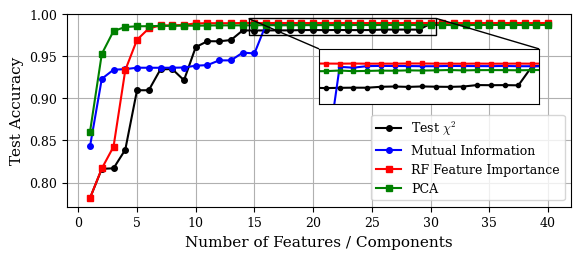

In [29]:
fig, ax = plt.subplots(figsize=(6.5, 2.5)) 

#Main plot
ax.plot(num_features_Chi, accuracies_Chi, marker='o', linestyle='-', color='k', markersize=4, label=r"Test $\chi^2$")
ax.plot(num_features_MI, accuracies_MI, marker='o', linestyle='-', color='b', markersize=4, label="Mutual Information")
ax.plot(num_features_RF, accuracies_RF, marker='s', linestyle='-', color='r', markersize=4, label="RF Feature Importance")
ax.plot(num_components_PCA, accuracies_PCA, marker='s', linestyle='-', color='g', markersize=4, label="PCA")

ax.set_xlabel("Number of Features / Components", fontsize=11)
ax.set_ylabel("Test Accuracy", fontsize=11)
ax.tick_params(axis='both', labelsize=9)
ax.legend(fontsize=9)
ax.grid(True)

#Zoom plot
axins = inset_axes(
    ax,
    width=2.2, height=0.55,  
    loc='upper left',
    bbox_to_anchor=(0.5, 0.82),  #Position
    bbox_transform=ax.transAxes,
    borderpad=0
)

axins.plot(num_features_Chi, accuracies_Chi, marker='o', linestyle='-', color='k', markersize=3)
axins.plot(num_features_MI, accuracies_MI, marker='o', linestyle='-', color='b', markersize=3)
axins.plot(num_features_RF, accuracies_RF, marker='s', linestyle='-', color='r', markersize=3)
axins.plot(num_components_PCA, accuracies_PCA, marker='s', linestyle='-', color='g', markersize=3)

axins.set_xticks([])
axins.set_yticks([])

axins.set_xlim(14.5, 30.5)
axins.set_ylim(0.975, 0.995)
axins.grid(True)

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="black",zorder=10)

plt.show()
plt.savefig("accuracy_vs_features.png", dpi=300)
fig.savefig("accuracy_vs_features.pdf", bbox_inches='tight')
plt.close()



Model size plot

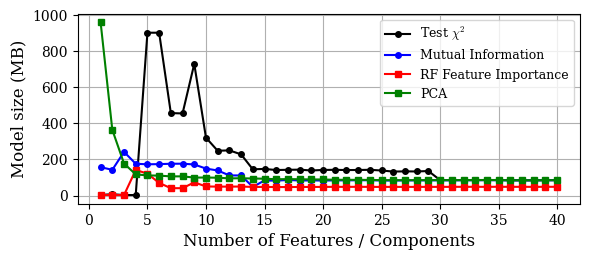

In [30]:
fig, ax = plt.subplots(figsize=(6, 2.7)) 

plt.plot(num_features_Chi, model_size_Chi, marker='o', linestyle='-', color='k', markersize=4, label=r"Test $\chi^2$")
plt.plot(num_features_MI, model_size_MI, marker='o', linestyle='-', color='b', markersize=4, label="Mutual Information")
plt.plot(num_features_RF, model_size_RF, marker='s', linestyle='-', color='r', markersize=4, label="RF Feature Importance")
plt.plot(num_components_PCA, model_size_PCA, marker='s', linestyle='-', color='g', markersize=4, label="PCA")

ax.set_xlabel("Number of Features / Components", fontsize=12)
ax.set_ylabel("Model size (MB)", fontsize=12)

ax.legend(fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("Size_vs_features.png", dpi=300)
fig.savefig("Size_vs_features.pdf", bbox_inches='tight')
plt.close()


Inference time plot

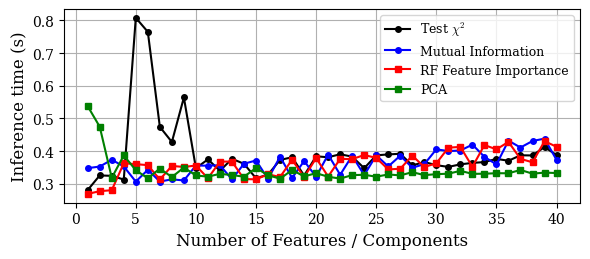

In [31]:
fig, ax = plt.subplots(figsize=(6, 2.7)) 

plt.plot(num_features_Chi, test_time_Chi, marker='o', linestyle='-', color='k', markersize=4, label=r"Test $\chi^2$")
plt.plot(num_features_MI, test_time_MI, marker='o', linestyle='-', color='b', markersize=4, label="Mutual Information")
plt.plot(num_features_RF, test_time_RF, marker='s', linestyle='-', color='r', markersize=4, label="RF Feature Importance")
plt.plot(num_components_PCA, test_time_PCA, marker='s', linestyle='-', color='g', markersize=4, label="PCA")

ax.set_xlabel("Number of Features / Components", fontsize=12)
ax.set_ylabel("Inference time (s)", fontsize=12)

ax.legend(fontsize=9)
ax.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("Time_vs_features.png", dpi=300)
fig.savefig("Time_vs_features.pdf", bbox_inches='tight')
plt.close()


**Chi2 model in detail**

In [43]:
selected_features = ['udp.stream', 'icmp.checksum', 'icmp.seq_le', 'http.content_length', 'tcp.ack_raw', 'icmp.transmit_timestamp', 'tcp.ack', 'dns.qry.name', 'tcp.checksum', 'tcp.dstport', 'tcp.seq', 'dns.qry.qu', 'dns_encoded', 'tcp.len', 'mqtt3_encoded', 'mqtt1_encoded', 'mqtt2_encoded', 'udp.time_delta', 'tcp.flags', 'mqtt.hdrflags', 'http.response', 'udp.port', 'tcp.connection.syn', 'mqtt.len', 'mqtt.msgtype', 'http1_encoded', 'tcp.flags.ack', 'tcp.connection.rst', 'mqtt.topic_len', 'http2_encoded', 'mqtt.proto_len']
X_train_chi = X_train[selected_features]
X_test_chi = X_test[selected_features]

rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_chi, y_train)

y_pred = rf_model.predict(X_test_chi)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "chi2_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save feature names
features_filename = os.path.join("RaspberryPi", "chi2_features.npy")
np.save(features_filename, np.array(selected_features))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    279925
           1     1.0000    1.0000    1.0000        72
           2     0.9098    0.9060    0.9079      7391
           3     0.9576    0.9665    0.9620      1938
           4     0.8686    0.8964    0.8823     10165
           5     0.9566    0.9489    0.9527      9709
           6     1.0000    1.0000    1.0000     10012
           7     0.8808    0.8549    0.8676      9987
           8     0.9985    0.9997    0.9991      3995
           9     0.9810    0.9805    0.9808     10005
          10     0.9850    0.9840    0.9845      4805
          11     0.8705    0.8945    0.8823      3014
          12     0.9935    0.8889    0.9383       171
          13     1.0000    1.0000    1.0000     24313
          14     0.9999    0.9999    0.9999     13588

    accuracy                         0.9888    389090
   macro avg     0.9601    0.9547    0.9572    389090
weighted avg     0.9888   

**MI model in detail**

In [44]:
selected_features = ['tcp.dstport', 'tcp.ack', 'tcp.ack_raw', 'http3_encoded', 'dns_encoded', 'mqtt1_encoded', 'mqtt2_encoded', 'mqtt3_encoded', 'http1_encoded', 'tcp.seq', 'tcp.flags', 'http2_encoded', 'tcp.flags.ack', 'tcp.len', 'tcp.checksum', 'udp.stream', 'icmp.checksum', 'icmp.seq_le']
X_train_mi = X_train[selected_features]
X_test_mi = X_test[selected_features]


rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_mi, y_train)

y_pred = rf_model.predict(X_test_mi)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "MI_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save feature names
features_filename = os.path.join("RaspberryPi", "MI_features.npy")
np.save(features_filename, np.array(selected_features))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    279925
           1     1.0000    1.0000    1.0000        72
           2     0.9101    0.9066    0.9084      7391
           3     0.9586    0.9675    0.9630      1938
           4     0.8677    0.8965    0.8818     10165
           5     0.9564    0.9484    0.9524      9709
           6     1.0000    1.0000    1.0000     10012
           7     0.8807    0.8534    0.8669      9987
           8     0.9985    0.9997    0.9991      3995
           9     0.9815    0.9796    0.9805     10005
          10     0.9854    0.9842    0.9848      4805
          11     0.8677    0.8965    0.8819      3014
          12     0.9871    0.8947    0.9387       171
          13     0.9999    1.0000    1.0000     24313
          14     0.9999    0.9997    0.9998     13588

    accuracy                         0.9887    389090
   macro avg     0.9596    0.9551    0.9571    389090
weighted avg     0.9888   

**Permutation Importance model in detail**

In [45]:
selected_features = ['udp.stream', 'icmp.seq_le', 'http2_encoded', 'tcp.ack', 'tcp.dstport', 'tcp.len', 'tcp.seq', 'tcp.connection.rst', 'tcp.ack_raw', 'http3_encoded', 'tcp.flags', 'http1_encoded', 'tcp.connection.synack', 'mqtt1_encoded']
X_train_fi = X_train[selected_features]
X_test_fi = X_test[selected_features]


rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_fi, y_train)

y_pred = rf_model.predict(X_test_fi)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "PFI_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save feature names
features_filename = os.path.join("RaspberryPi", "PFI_features.npy")
np.save(features_filename, np.array(selected_features))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    279925
           1     1.0000    1.0000    1.0000        72
           2     0.9375    0.8987    0.9177      7391
           3     1.0000    0.9391    0.9686      1938
           4     0.9164    0.8521    0.8831     10165
           5     0.9529    0.9822    0.9673      9709
           6     1.0000    1.0000    1.0000     10012
           7     0.8261    0.9104    0.8662      9987
           8     0.9985    0.9997    0.9991      3995
           9     0.9886    0.9805    0.9845     10005
          10     0.9756    0.9998    0.9876      4805
          11     0.9428    0.8752    0.9078      3014
          12     0.9760    0.9532    0.9645       171
          13     1.0000    1.0000    1.0000     24313
          14     1.0000    0.9999    0.9999     13588

    accuracy                         0.9897    389090
   macro avg     0.9676    0.9594    0.9631    389090
weighted avg     0.9899   

PCA model in detail

In [46]:
X_train_pca = X_train_pca_full[:, :22]  
X_test_pca = X_test_pca_full[:, :22]

rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=10)
rf_model.fit(X_train_pca, y_train)

y_pred = rf_model.predict(X_test_pca)

print(classification_report(y_test, y_pred, digits=4))

# Save model
model_filename = os.path.join("RaspberryPi", "PCA_model.pkl")
with open(model_filename, "wb") as f:
    pickle.dump(rf_model, f)    

# Save principal components
np.save("RaspberryPi/X_test_pca.npy", X_test_pca.astype(np.float16))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    279925
           1     1.0000    1.0000    1.0000        72
           2     0.9039    0.8958    0.8998      7391
           3     0.9364    0.9417    0.9390      1938
           4     0.8665    0.8866    0.8764     10165
           5     0.9359    0.9345    0.9352      9709
           6     1.0000    1.0000    1.0000     10012
           7     0.8679    0.8531    0.8604      9987
           8     0.9980    0.9997    0.9989      3995
           9     0.9745    0.9636    0.9690     10005
          10     0.9742    0.9754    0.9748      4805
          11     0.8440    0.8796    0.8614      3014
          12     0.9932    0.8480    0.9148       171
          13     1.0000    1.0000    1.0000     24313
          14     0.9999    0.9999    0.9999     13588

    accuracy                         0.9871    389090
   macro avg     0.9530    0.9452    0.9487    389090
weighted avg     0.9872   